In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os, sys
import glob
import tqdm

In [3]:
from sklearn.preprocessing import StandardScaler, scale
import scipy

In [4]:
from smdl import SMDL
from model import Norm

In [5]:
from volatility_detector import VolatilityDetector

In [6]:
def detect_change_points_maxscore(scores):
    scoress = np.array(scores)
    idxes_scores_positive = np.where(scores > 0)[0]
    
    idxes_end = np.where(
                              np.diff(idxes_scores_positive) > 1
                          )[0]
    end = idxes_scores_positive[idxes_end]

    idxes_start = idxes_end + 1  
    if 0 not in idxes_start:
        idxes_start = np.hstack((0, idxes_start))

    start = idxes_scores_positive[idxes_start]

    if idxes_scores_positive[idxes_start[1]-1] not in end:
        end = np.hstack((idxes_scores_positive[idxes_start[1] - 1], end))
    if idxes_scores_positive[-1] not in end:
        end = np.hstack((end, idxes_scores_positive[-1]))

    change_points = []
    for s, e in zip(start, end):
        cp = s + np.argmax(scores[s:e+1])
        change_points.append(cp)

    change_points = np.array(change_points)
    return change_points

In [7]:
def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

#def nearPD(A, nit=10):
def nearPD(A, nit=100):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be Identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

In [8]:
outdir = '../../output/experiment5'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [9]:
h = 250

In [10]:
df = pd.read_csv('../../data/factory_sensor.csv')

In [11]:
X, y = df.loc[:, 'X1':'X8'].values, df['y'].values

In [12]:
idxes_event = np.where(y==1)[0]

In [13]:
for j in range(X.shape[1]):
    sc = StandardScaler()
    sc.fit(X[:h, j].reshape(-1, 1))
    X[:, j] = sc.transform(X[:, j].reshape(-1, 1)).ravel()

In [14]:
T = X.shape[0]
mu_max = 60
sigma_min = 0.001

scores_smdl = [np.nan] * h
model = Norm()
for i in tqdm.tqdm(range(h, T-h)):
    scores_smdl.append(model.calc_change_score(X[(i-h):(i+h), :], h, mu_max=mu_max, sigma_min=sigma_min))
scores_smdl += [np.nan] * h

100%|██████████| 25950/25950 [00:53<00:00, 486.26it/s]


In [15]:
threshold = 0.3

In [16]:
change_points_smdl = detect_change_points_maxscore(np.array(scores_smdl)-threshold)

/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
change_points_smdl.shape

(97,)

In [18]:
change_points_diff_smdl = np.diff(change_points_smdl)
vdetector_smdl = VolatilityDetector(b=10, r=10)
relvol_smdl = np.array([vdetector_smdl.detect(cpd) for cpd in change_points_diff_smdl])

In [19]:
r = 0.1
lambdas_hat = np.array(
    [(1 - (1-r)**(i+1)) / \
     (r * np.sum( (1-r)**np.arange(i, -1, -1) * change_points_diff_smdl[:i+1] )) \
     for i in range(len(change_points_diff_smdl))]
)
codelen_time_smdl = -np.log(lambdas_hat[:-1]) + lambdas_hat[:-1] * change_points_diff_smdl[1:]
change_rate_codelen_smdl = np.abs(np.diff(codelen_time_smdl) / codelen_time_smdl[:-1])

In [20]:
metachange_stats_smdl = []

for i, cp in enumerate(change_points_smdl):
    mean1 = np.mean(X[(cp-h):cp, :], axis=0)
    cor1 = np.corrcoef(X[(cp-h):cp, :], rowvar=False)
    mean2 = np.mean(X[(cp+1):(cp+h+1), :], axis=0)
    cor2 = np.corrcoef(X[(cp+1):(cp+h+1), :], rowvar=False)
    
    if i == 0:
        mean1_prev, cor1_prev = mean1, cor1
        mean2_prev, cor2_prev = mean2, cor2
        continue

    metachange_up = np.mean(-scipy.stats.multivariate_normal(mean1 + (mean2_prev - mean1_prev), nearPD(cor1 + (cor2_prev - cor1_prev)), allow_singular=True).logpdf(X[(cp+1):(cp+h+1), :]))
    metachange_down = np.mean(-scipy.stats.multivariate_normal(mean1 - (mean2_prev - mean1_prev), nearPD(cor1 - (cor2_prev - cor1_prev)), allow_singular=True).logpdf(X[(cp+1):(cp+h+1), :]))

    metachange = np.nanmin([metachange_up, metachange_down])

    metachange_stats_smdl.append(metachange)

    mean1_prev, cor1_prev = mean1, cor1
    mean2_prev, cor2_prev = mean2, cor2

metachange_stats_smdl = np.array(metachange_stats_smdl)

In [21]:
lam = 0.2
codelen_integrated_smdl = codelen_time_smdl + lam * metachange_stats_smdl[1:]

In [22]:
change_rate_state_smdl = np.abs(np.diff(metachange_stats_smdl) / metachange_stats_smdl[:-1])

In [23]:
change_rate_integrated_smdl = np.abs(np.diff(codelen_integrated_smdl)/codelen_integrated_smdl[:-1])

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparen

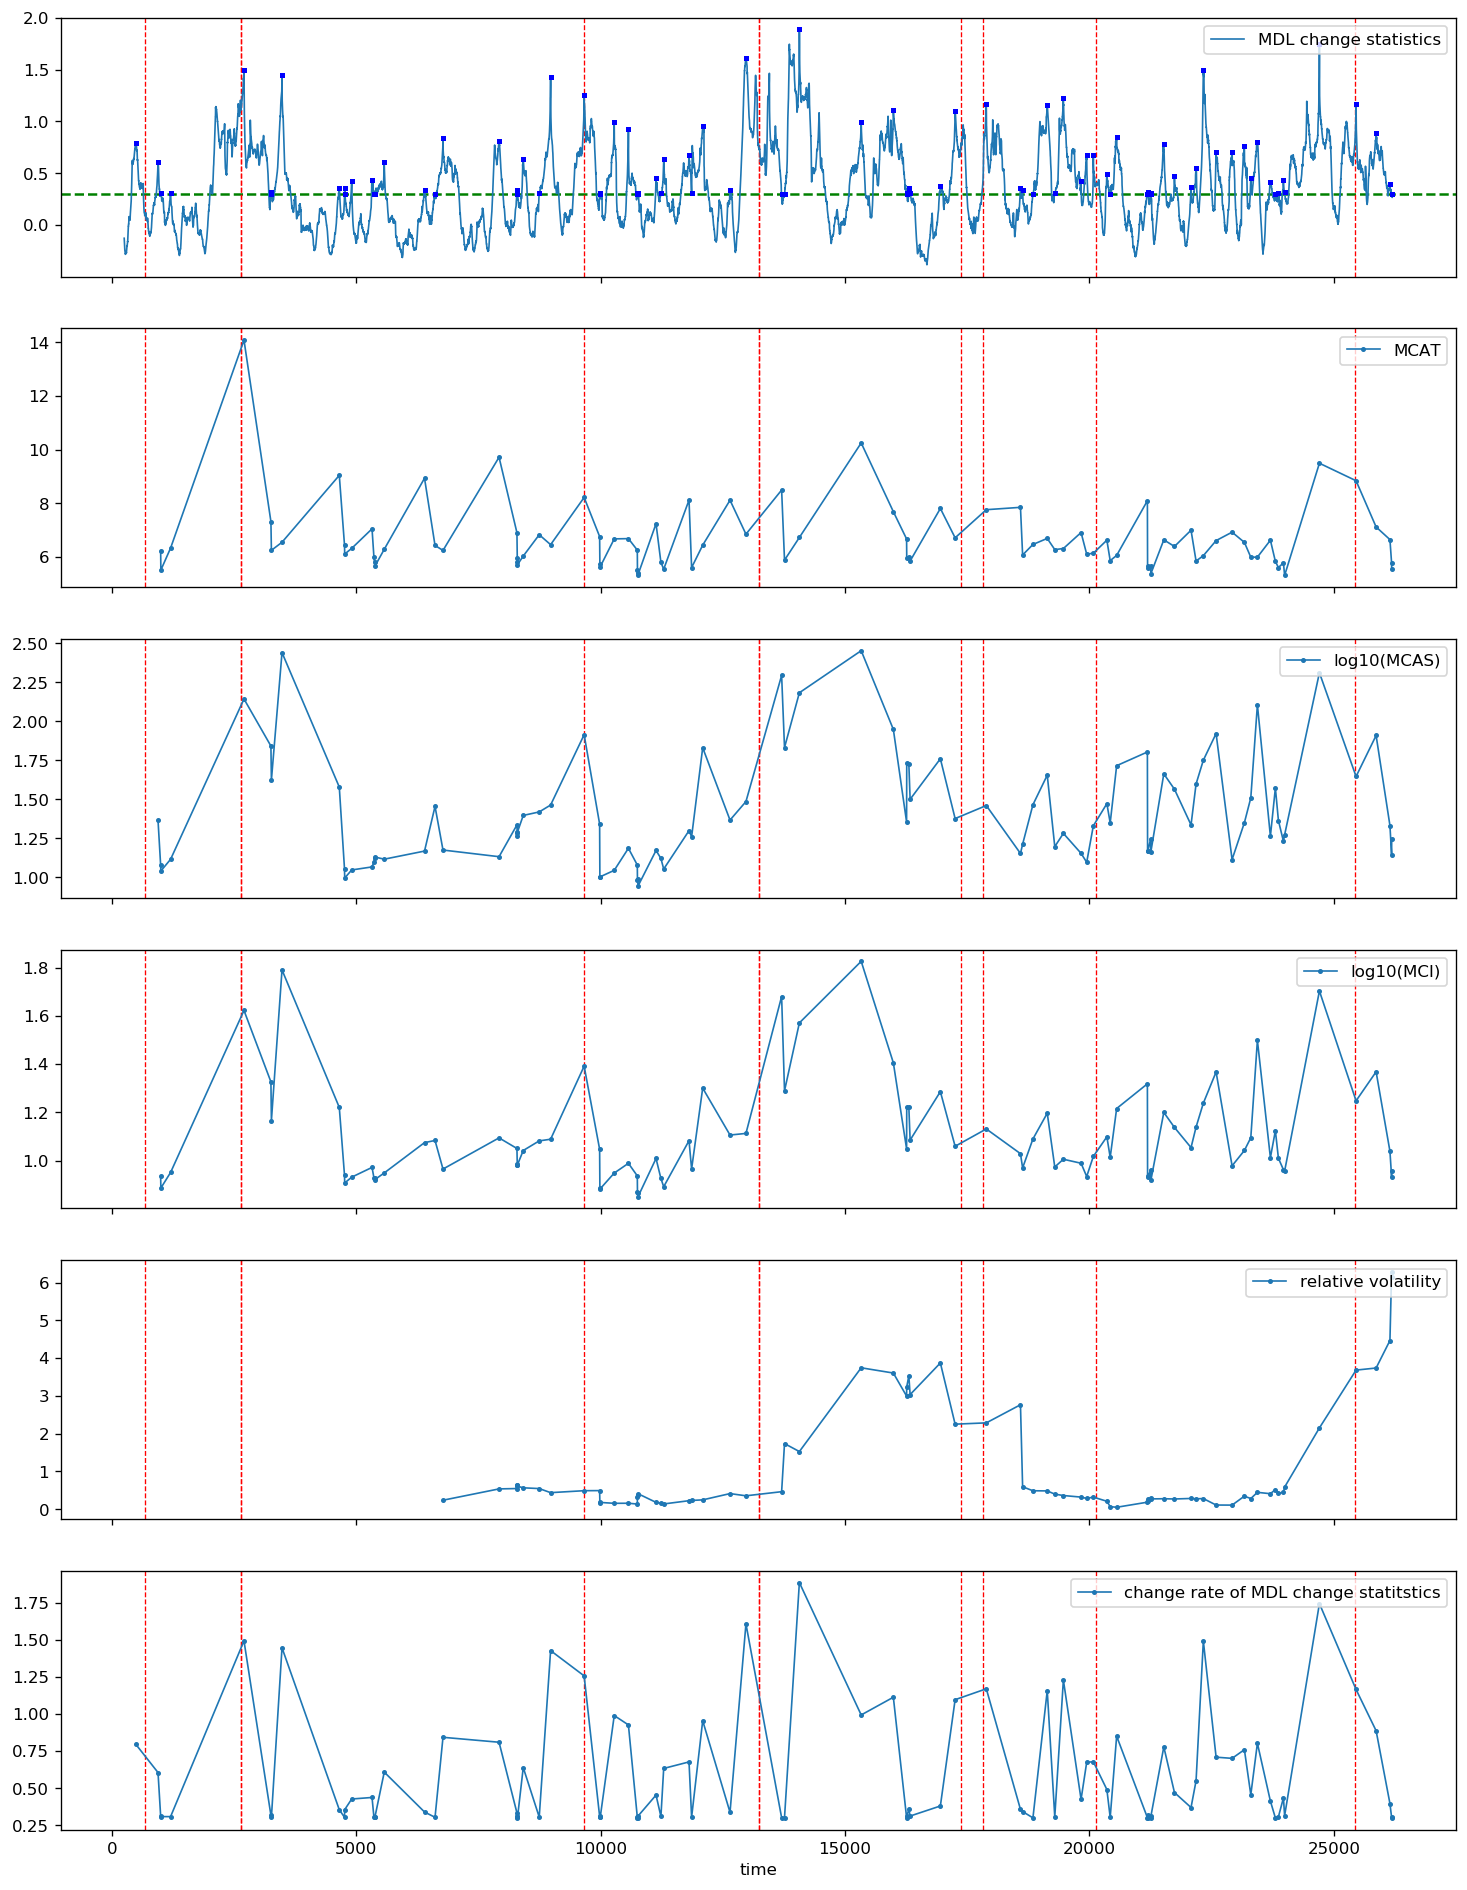

In [24]:
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(15, 20), dpi=120)
axes[0].plot(np.array(scores_smdl), linewidth=1, label='MDL change statistics')
axes[0].legend(loc='upper right', prop={'size': 10})
for idx in change_points_smdl:
    axes[0].plot(change_points_smdl, np.array(scores_smdl)[change_points_smdl], markersize=2, marker='o', color='blue', linestyle='', zorder=2)
axes[0].axhline(threshold, color='green', linestyle='--', zorder=1)
    
axes[1].plot(change_points_smdl[2:], codelen_time_smdl, 
             linewidth=1, markersize=2, marker='o', 
             label='MCAT')
axes[1].legend(loc='upper right', prop={'size': 10})

axes[2].plot(change_points_smdl[1:], np.log10(metachange_stats_smdl), 
             linewidth=1, markersize=2, marker='o', 
             label='log10(MCAS)')
axes[2].legend(loc='upper right', prop={'size': 10})

axes[3].plot(change_points_smdl[2:], np.log10(codelen_integrated_smdl), 
             linewidth=1, markersize=2, marker='o', 
             label='log10(MCI)')
axes[3].legend(loc='upper right', prop={'size': 10})

axes[4].plot(change_points_smdl[1:], relvol_smdl, 
             linewidth=1, markersize=2, marker='o',
             label='relative volatility'
            )
axes[4].legend(loc='upper right', prop={'size': 10})

axes[5].plot(change_points_smdl, np.array(scores_smdl)[change_points_smdl], 
             linewidth=1, markersize=2, marker='o',
             label='change rate of MDL change statitstics')
axes[5].set_xlabel('time')
axes[5].legend(loc='upper right', prop={'size': 10})
    
for i in range(6):
    for idx in idxes_event:
        axes[i].axvline(idx, color='red', linestyle='--', linewidth=0.8, zorder=1)
    
plt.savefig(os.path.join(outdir, 'result_smdl.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'result_smdl.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'result_smdl.png'), bbox_inches='tight')